In [1]:
import sys
#sys.path.insert(0, '../third/xgboost.m/python-package/build/lib/')
sys.path.insert(0, '../third/xgboost/python-package/build/lib/')

In [2]:
%pylab inline
import pandas as pd
import xgboost as xgb

Populating the interactive namespace from numpy and matplotlib


In [3]:
xgb.__version__

''

In [4]:
df=pd.read_csv('../input/train2016_withy.csv')

In [5]:
df=df.loc[np.random.permutation(df.index)]

In [6]:
trainx=df.drop(['parcelid','logerror'],axis=1)
trainy=df['logerror']

In [7]:
trainx.shape

(90811, 95)

In [8]:
split = 80000
x_train, y_train, x_valid, y_valid = trainx[:split], trainy[:split], trainx[split:], trainy[split:]

print('Building DMatrix...')

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)




Building DMatrix...


In [9]:
print('Training ...')

params = {}
params['eta'] = 0.02
params['objective'] = 'reg:smoothl1'
#params['objective'] = 'reg:abs'
params['eval_metric'] = 'mae'
params['max_depth'] = 8
params['silent'] = 1
params['gamma'] = 2
params['min_child_weight']=50
params['tree_method']='hist'

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
clf = xgb.train(params, d_train, 240, watchlist, early_stopping_rounds=50, verbose_eval=10)


Training ...
[0]	train-mae:0.478317	valid-mae:0.479033
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 50 rounds.
[10]	train-mae:0.289296	valid-mae:0.290846
[20]	train-mae:0.121435	valid-mae:0.123327
[30]	train-mae:0.066796	valid-mae:0.070479
[40]	train-mae:0.065284	valid-mae:0.070082
[50]	train-mae:0.064464	valid-mae:0.070089
[60]	train-mae:0.063996	valid-mae:0.070111
[70]	train-mae:0.063344	valid-mae:0.070236
[80]	train-mae:0.062941	valid-mae:0.070304
Stopping. Best iteration:
[38]	train-mae:0.065496	valid-mae:0.070077



In [10]:
0.991688/15.

0.06611253333333333

In [11]:
clf.best_ntree_limit

39

In [12]:
print clf.get_dump(dump_format='text')[7]

0:[yearbuilt<1950] yes=1,no=2,missing=1
	1:[taxamount<2748.96] yes=3,no=4,missing=4
		3:[latitude<3.36632e+07] yes=7,no=8,missing=7
			7:leaf=-0.0129678
			8:[yearbuilt<1930] yes=15,no=16,missing=15
				15:[taxdelinquencyyear<14.5] yes=29,no=30,missing=30
					29:leaf=-0.0131474
					30:[calculatedfinishedsquarefeet<24] yes=51,no=52,missing=52
						51:leaf=-0.0141065
						52:[lotsizesquarefeet<87] yes=69,no=70,missing=69
							69:leaf=-0.0182424
							70:[finishedsquarefeet12<58] yes=77,no=78,missing=78
								77:leaf=-0.0179578
								78:leaf=-0.0132588
				16:leaf=-0.0188598
		4:[taxdelinquencyyear<7.5] yes=9,no=10,missing=9
			9:leaf=-0.0192199
			10:[finishedsquarefeet12<30] yes=19,no=20,missing=19
				19:leaf=-0.0142828
				20:leaf=-0.0184161
	2:[finishedsquarefeet12<81] yes=5,no=6,missing=6
		5:[taxamount<2917.3] yes=11,no=12,missing=12
			11:[propertycountylandusecode_XXXX<0] yes=21,no=22,missing=21
				21:leaf=-0.0192667
				22:[landtaxvaluedollarcnt<37739] yes=43,no=44,m

In [13]:
import json
trees=[json.loads(u) for u in clf.get_dump(dump_format='json')[:clf.best_ntree_limit]]
len(trees)

39

In [14]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

In [15]:
tree= (trees[7])

In [16]:
g=nx.DiGraph()

In [17]:
def addNode(node):
    g.add_node(node['nodeid'])
    if 'children' in node:
        for u in node['children']:
            addNode(u)
addNode(tree)            

In [18]:
def addEdge(node):
    n1=node['nodeid']
    if 'children' in node:
        for u in node['children']:
            g.add_edge(n1,u['nodeid'])
            addEdge(u)
addEdge(tree)            

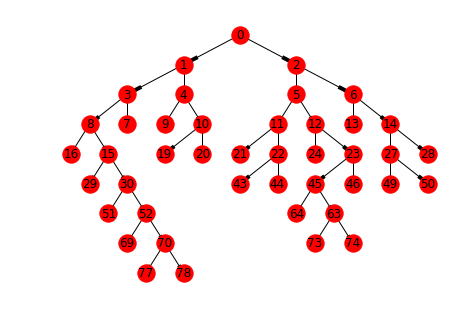

In [20]:
pos=graphviz_layout(g, prog='dot')
nx.draw(g,pos,with_labels=True)

In [135]:
def parse_tree_(node):
    if 'leaf' in node:
        return [[]]
    nodeid=node['nodeid']
    split=node['split']
    split_cond=node['split_condition']
    yes=node['yes']
    no=node['no']
    missing=node['missing']
    children1=parse_tree_([u for u in node["children"] if u['nodeid']==yes][0])
    children2=parse_tree_([u for u in node["children"] if u['nodeid']==no][0])
    cond1=[('yes',split,split_cond)]
    cond2=[('no',split,split_cond)]
    if missing==yes:
        cond1.append(('missing',split))
    elif missing==no:
        cond2.append(('missing',split))
    else:
        raise 2
    ret1=[[cond1]+u for u in children1]
    ret2=[[cond2]+u for u in children2]
    return ret1+ret2
    
def parse_tree(node):
    ret=parse_tree_(node)
    ret=[tuple(tuple(v) for v in u) for u in ret]
    return ret
        

In [136]:
parse_tree(trees[0])

[((('yes', u'finishedsquarefeet12', 26), ('missing', u'finishedsquarefeet12')),
  (('yes', u'finishedsquarefeet12', 21),)),
 ((('yes', u'finishedsquarefeet12', 26), ('missing', u'finishedsquarefeet12')),
  (('no', u'finishedsquarefeet12', 21), ('missing', u'finishedsquarefeet12'))),
 ((('no', u'finishedsquarefeet12', 26),),
  (('yes', u'taxamount', 2777.19),),
  (('yes', u'yearbuilt', 1928), ('missing', u'yearbuilt'))),
 ((('no', u'finishedsquarefeet12', 26),),
  (('yes', u'taxamount', 2777.19),),
  (('no', u'yearbuilt', 1928),)),
 ((('no', u'finishedsquarefeet12', 26),),
  (('no', u'taxamount', 2777.19), ('missing', u'taxamount')))]

In [138]:
def enumerate_all_conds(tree):
    ret=[]
    cond_list=(parse_tree(tree))
    for cond in cond_list:
        for i in range(len(cond)):
            ret.append(cond[:i+1])
    return ret

In [139]:
cond_list=(enumerate_all_conds(trees[8]))
len(cond_list)

73

In [154]:
def value_cond_tuple (df,cond):
    #print cond
    col=cond[1]
    if cond[0]=='missing':
        return np.isnan(df[col])
    else:
        split_val=cond[2]
        if cond[0]=='yes':
            return df[col]<split_val
        elif cond[0]=='no':
            return df[col]>=split_val
        else:
            raise "never be here"
def value_cond_single(df,conds):
    return reduce(lambda u,v: u | v, [value_cond_tuple(df,cond) for cond in conds])
def value_cond(df,conds):
    return reduce(lambda u,v: u & v, [value_cond_single(df,cond) for cond in conds])
def value_trees(df,trees):
    cond_lists=reduce(lambda u,v: u+v, [enumerate_all_conds(tree) for tree in trees])
    cond_lists=list(set(cond_lists))
    print len(cond_lists)
    return cond_lists, pd.DataFrame([value_cond(df, conds) for conds in cond_lists]).T

In [155]:
len(trees)

39

In [156]:
%time a,b=value_trees(df,trees)

5458
CPU times: user 55.2 s, sys: 92.8 ms, total: 55.3 s
Wall time: 55.3 s


In [157]:
b.shape

(90811, 5458)

In [158]:
b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90811 entries, 58308 to 80350
Columns: 5458 entries, Unnamed 0 to Unnamed 5419
dtypes: bool(5458)
memory usage: 473.4 MB


In [159]:
c=b.sum(0)

In [160]:
c.min()

51

In [161]:
len(a),len(b),b.shape

(5458, 90811, (90811, 5458))

In [162]:
X=b.values
y=trainy.values*15
X.shape,y.shape

((90811, 5458), (90811,))

In [163]:
def do_shuffle(X,y):
    idx = np.random.permutation(range(len(X)))
    X = X[idx]     
    y= y[idx]
    return X,y

In [164]:
import tensorflow as tf
def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.2)
    return tf.Variable(initial, name=name)

def bias_variable(shape, name):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=name)


In [165]:
tf.reset_default_graph()

px = tf.placeholder("float", shape=[None, X.shape[1]], name='input_x')
py = tf.placeholder("float", shape=[None, 1], name='input_y')
alpha=tf.placeholder("float",shape=())
w = weight_variable(shape=[int(X.shape[-1]), 1], name=None)
w_mask=tf.placeholder("float", shape=w.get_shape(), name='w_mask')
b = bias_variable(shape=[1], name=None)
h1 = tf.matmul(px, w*w_mask) + b
absloss=tf.reduce_mean(tf.abs(h1-py))
loss=absloss+alpha*tf.reduce_mean(tf.abs(w*w_mask))
loss2=absloss+alpha*tf.reduce_mean((w*w_mask)**2)
optimizer1 = tf.train.AdamOptimizer().minimize(loss)
optimizer2 = tf.train.AdamOptimizer(0.01).minimize(loss2)
#optimizer3 = tf.train.AdagradDAOptimizer(0.01).minimize(loss)

In [166]:
COUNT=0
def make_batch(bs=1024, shuffle=False):
    global X,y,COUNT
    n=X.shape[0]
    if shuffle and COUNT+bs>n:
        X,y=do_shuffle(X,y)
        COUNT=0
    bx,by=X[COUNT:COUNT+bs],y[COUNT:COUNT+bs]
    COUNT+=bs
    return bx.astype(np.float32),by.astype(np.float32).reshape([-1,1])


In [167]:
print h1.get_shape(),loss.get_shape(),w.get_shape()

(?, 1) () (5458, 1)


In [168]:
sess=tf.Session()
init_op = tf.global_variables_initializer()        
sess.run(init_op) 

In [169]:
np.min(np.abs(w.eval(sess)))

2.4303952e-05

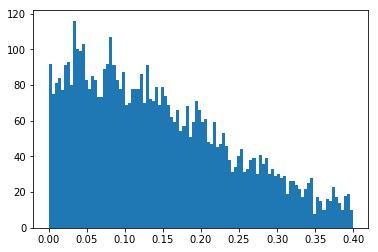

In [170]:
plt.hist(np.abs(w.eval(sess)),bins=100);

In [171]:
mask_value=np.ones(w.get_shape())

In [172]:
X.shape,1024*100

((90811, 5458), 102400)

In [173]:
v_alpha=500
old_w=w.eval(sess).copy()

In [174]:
if 1:      
    for i in range(10000):
        xb,yb=make_batch(shuffle=True)

        #if np.sum(mask_value)<500: break
        #print xb.shape,yb.shape
        if True or np.sum(mask_value)>500: 
            this_optimizer=optimizer1
        else:
            this_optimizer=optimizer2
        feed_dict = {px:xb, py:yb,w_mask:mask_value,alpha:v_alpha}
        _, loss1, loss2 = sess.run([this_optimizer, loss, absloss],feed_dict=feed_dict)
        thisw=w.eval(sess).copy()
        maxd=np.max(np.abs(thisw-old_w))
        old_w=thisw
        if i%100==0:             
            print "{}: Loss:{}, MAE:{}, #zero_w: {}, max delta w: {}".format(i, loss1,loss2,np.sum(mask_value),maxd)

0: Loss:74.1240310669, MAE:2.09762430191, #zero_w: 5458.0, max delta w: 0.00100000202656
100: Loss:33.9193687439, MAE:1.43057537079, #zero_w: 5458.0, max delta w: 0.00123876333237
200: Loss:12.1349840164, MAE:1.19450736046, #zero_w: 5458.0, max delta w: 0.00142024457455
300: Loss:3.17938137054, MAE:1.04819774628, #zero_w: 5458.0, max delta w: 0.00138756632805
400: Loss:1.08516955376, MAE:0.968854248524, #zero_w: 5458.0, max delta w: 0.00182296149433
500: Loss:1.07307422161, MAE:1.01112258434, #zero_w: 5458.0, max delta w: 0.000936223194003
600: Loss:1.06707012653, MAE:1.00798535347, #zero_w: 5458.0, max delta w: 0.000316142337397
700: Loss:1.12008047104, MAE:1.05989408493, #zero_w: 5458.0, max delta w: 0.000384461949579
800: Loss:1.0442763567, MAE:0.985248565674, #zero_w: 5458.0, max delta w: 0.000323701824527
900: Loss:1.10618114471, MAE:1.04720211029, #zero_w: 5458.0, max delta w: 0.000353335344698
1000: Loss:1.11788344383, MAE:1.05832397938, #zero_w: 5458.0, max delta w: 0.000321392

KeyboardInterrupt: 

In [185]:
COUNT=0
xb,yb=make_batch(X.shape[0])

In [187]:
if 1: 

    print xb.shape,yb.shape
    for i in range(10000):
        #if np.sum(mask_value)<500: break
        #xb,yb=make_batch(shuffle=True)        
        #print xb.shape,yb.shape
        if  np.sum(mask_value)>500: 
            this_optimizer=optimizer1
        else:
            v_alpha=1
            this_optimizer=optimizer2
        feed_dict = {px:xb, py:yb,w_mask:mask_value,alpha:v_alpha}
        _, loss1, loss2 = sess.run([this_optimizer, loss, absloss],feed_dict=feed_dict)
        thisw=w.eval(sess).copy()
        maxd=np.max(np.abs(thisw-old_w)*mask_value)
        old_w=thisw
        if i%1==0:
            if i%50==0 and i>10 and np.sum(mask_value)>500:
                mask_value=(np.abs(thisw)>1e-5)*mask_value              
            print "{}: Loss:{}, MAE:{}, #zero_w: {}, max delta w: {}".format(i, loss1,loss2,np.sum(mask_value),maxd)

(90811, 5458) (90811, 1)
0: Loss:1.02041721344, MAE:1.01188468933, #zero_w: 493.0, max delta w: 0.00384180247784
1: Loss:1.020403862, MAE:1.01187491417, #zero_w: 493.0, max delta w: 0.00180177390575
2: Loss:1.02039849758, MAE:1.01187252998, #zero_w: 493.0, max delta w: 0.00169476866722
3: Loss:1.02036190033, MAE:1.01183915138, #zero_w: 493.0, max delta w: 0.00170266628265
4: Loss:1.02030456066, MAE:1.01178491116, #zero_w: 493.0, max delta w: 0.0017092525959
5: Loss:1.02026927471, MAE:1.01175284386, #zero_w: 493.0, max delta w: 0.00171467661858
6: Loss:1.02024543285, MAE:1.01173186302, #zero_w: 493.0, max delta w: 0.00171905755997
7: Loss:1.02020955086, MAE:1.01169872284, #zero_w: 493.0, max delta w: 0.00172245502472
8: Loss:1.02017402649, MAE:1.01166582108, #zero_w: 493.0, max delta w: 0.00172501802444
9: Loss:1.02015829086, MAE:1.01165258884, #zero_w: 493.0, max delta w: 0.00170528888702
10: Loss:1.02014875412, MAE:1.01164543629, #zero_w: 493.0, max delta w: 0.0016870200634
11: Loss:1

KeyboardInterrupt: 

In [188]:
w_val=w.eval(sess)*mask_value
b_val=b.eval(sess)[0]

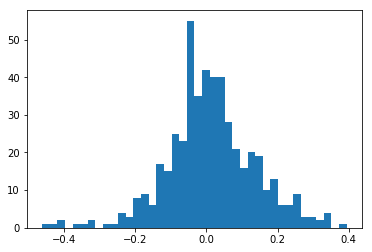

In [196]:
plt.hist(w_val[w_val!=0],bins=40);

In [189]:
b_val

0.135397

In [190]:
np.mean(mask_value)

0.09032612678636863

In [191]:
pred=np.sum(X*w_val.reshape(1,-1),1)+b_val

In [192]:
np.mean(np.abs(y-pred))/15

0.067420786695426865

In [179]:
a[0]

((('yes', u'finishedsquarefeet12', 56),),
 (('no', u'taxamount', 2370.88),),
 (('yes', u'yearbuilt', 1983), ('missing', u'yearbuilt')),
 (('yes', u'calculatedfinishedsquarefeet', 44),
  ('missing', u'calculatedfinishedsquarefeet')),
 (('yes', u'taxamount', 3545.49), ('missing', u'taxamount')),
 (('no', u'structuretaxvaluedollarcnt', 57098),),
 (('no', u'calculatedfinishedsquarefeet', 40),))

In [177]:
np.where(mask_value>0)

(array([   0,    5,   18,   51,   64,   65,   79,   88,   95,  104,  110,
         122,  127,  131,  133,  148,  155,  157,  160,  185,  197,  202,
         215,  217,  237,  239,  257,  262,  268,  299,  301,  302,  306,
         310,  319,  320,  326,  340,  343,  348,  377,  391,  393,  404,
         409,  460,  473,  477,  491,  493,  511,  514,  516,  518,  535,
         558,  563,  580,  581,  586,  595,  610,  627,  641,  650,  653,
         690,  704,  721,  736,  737,  763,  768,  773,  774,  785,  793,
         797,  820,  828,  833,  835,  845,  865,  869,  914,  927,  947,
         950,  959,  961,  964,  971,  981, 1004, 1007, 1024, 1048, 1059,
        1069, 1086, 1089, 1131, 1139, 1146, 1149, 1155, 1156, 1168, 1171,
        1175, 1178, 1184, 1192, 1223, 1231, 1233, 1237, 1248, 1257, 1277,
        1308, 1320, 1321, 1360, 1361, 1379, 1380, 1388, 1403, 1407, 1409,
        1421, 1444, 1453, 1478, 1490, 1495, 1499, 1505, 1531, 1541, 1547,
        1568, 1575, 1584, 1601, 1614, 

In [219]:
np.mean(np.abs(y-pred))/15

0.06877882272807595

In [ ]:
0.918024539948/15

In [159]:
np.mean(np.abs(y-np.median(y)))/15

0.069017504487341841